<a href="https://colab.research.google.com/github/varun-beep/DeepLearning/blob/main/DL_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install tensorflow-addons


In [1]:
pip install tensorflow==2.15.0 tensorflow-addons

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils import compute_class_weight
import tensorflow_addons as tfa

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils import compute_class_weight


In [31]:
# Load dataset
df = pd.read_csv("/content/heart_disease_uci.csv")

In [32]:
# Drop unnecessary columns
df = df.drop(columns=['id'], errors='ignore')

# Identify categorical columns
categorical_cols = ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']

# Handling missing values
numerical_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Handling the 'dataset' column (contains city names like 'Cleveland')
if 'dataset' in df.columns:
    df = pd.get_dummies(df, columns=['dataset'], drop_first=True)  # One-Hot Encoding

# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Standardizing numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Ensure all columns are numeric
df = df.apply(pd.to_numeric)

# Creating separate datasets for multi-class and binary classification
df_multi_class = df.copy()
df_binary_class = df.copy()
df_binary_class['num'] = df_binary_class['num'].apply(lambda x: 1 if x > 0 else 0)

# Splitting data
X_multi = df_multi_class.drop(columns=['num'])
y_multi = df_multi_class['num']
X_bin = df_binary_class.drop(columns=['num'])
y_bin = df_binary_class['num']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)



<ipython-input-32-3a926154d414>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])


In [33]:
# Function to create DFN model
def create_dfn(activation='relu', optimizer='adam', reg=None, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train_bin.shape[1],), kernel_regularizer=reg))
    for _ in range(4):
        model.add(Dense(64, activation=activation, kernel_regularizer=reg))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
# Train and evaluate models
activations = ['relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'sgd']
regularizations = [None, l1(0.01), l2(0.01)]
dropout_rates = [0.0, 0.3]

results = []

for activation in activations:
    for optimizer in optimizers:
        for reg in regularizations:
            for dropout in dropout_rates:
                model = create_dfn(activation=activation, optimizer=optimizer, reg=reg, dropout_rate=dropout)
                model.fit(X_train_bin, y_train_bin, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
                y_pred = (model.predict(X_test_bin) > 0.5).astype(int)

                accuracy = accuracy_score(y_test_bin, y_pred)
                precision = precision_score(y_test_bin, y_pred)
                recall = recall_score(y_test_bin, y_pred)
                f1 = f1_score(y_test_bin, y_pred)

                results.append({
                    'Activation': activation,
                    'Optimizer': optimizer,
                    'Regularization': reg,
                    'Dropout': dropout,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-score': f1
                })

# Convert results to DataFrame and analyze
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [35]:
print(df_binary_class['num'].value_counts())

num
1    509
0    411
Name: count, dtype: int64


In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train_bin, y_train_bin)
feature_importances = pd.Series(rf.feature_importances_, index=X_train_bin.columns).sort_values(ascending=False)
print(feature_importances)

thalch                      0.120321
chol                        0.119524
oldpeak                     0.114796
age                         0.093955
exang_True                  0.084142
trestbps                    0.077935
cp_atypical angina          0.065416
sex_Male                    0.058621
dataset_Switzerland         0.034699
cp_non-anginal              0.031576
ca                          0.028450
thal_normal                 0.027553
fbs                         0.025181
dataset_VA Long Beach       0.018176
slope_upsloping             0.017384
restecg_normal              0.015911
dataset_Hungary             0.015745
thal_reversable defect      0.013767
cp_typical angina           0.013607
restecg_st-t abnormality    0.011724
slope_flat                  0.011519
dtype: float64


In [37]:
# Ensure no NaN values before SMOTE
if df.isnull().sum().sum() > 0:
    df = df.fillna(df.median())

# Handling class imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin), y=y_train_bin)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Re-check for NaNs before applying SMOTE
X_train_bin = X_train_bin.dropna()
y_train_bin = y_train_bin.loc[X_train_bin.index]

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_bin, y_train_bin)

In [38]:
# Drop unnecessary columns
df = df.drop(columns=['id'], errors='ignore')

# Handling missing values with improved column checks
categorical_cols = ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
numerical_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

available_categorical_cols = [col for col in categorical_cols if col in df.columns]
available_numerical_cols = [col for col in numerical_cols if col in df.columns]

if available_categorical_cols:
    df[available_categorical_cols] = df[available_categorical_cols].fillna(df[available_categorical_cols].mode().iloc[0])

if available_numerical_cols:
    df[available_numerical_cols] = df[available_numerical_cols].fillna(df[available_numerical_cols].median())

# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=available_categorical_cols, drop_first=True)

# Standardizing numerical features
scaler = StandardScaler()
if available_numerical_cols:
    df[available_numerical_cols] = scaler.fit_transform(df[available_numerical_cols])

# Ensure all columns are numeric
df = df.apply(pd.to_numeric)

# Removing less relevant categorical features
df = df.drop(columns=['dataset_Switzerland', 'dataset_Hungary', 'dataset_VA Long Beach'], errors='ignore')

# Creating separate datasets for multi-class and binary classification
df_multi_class = df.copy()
df_binary_class = df.copy()
df_binary_class['num'] = df_binary_class['num'].apply(lambda x: 1 if x > 0 else 0)

# Splitting data
X_multi = df_multi_class.drop(columns=['num'])
y_multi = df_multi_class['num']
X_bin = df_binary_class.drop(columns=['num'])
y_bin = df_binary_class['num']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

# Handling class imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin), y=y_train_bin)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_bin, y_train_bin)

In [39]:
# Function to create DFN model
def create_dfn(activation='relu', optimizer='adam', reg=None, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train_bin.shape[1],)))
    model.add(Dense(64, activation=activation, kernel_regularizer=reg))
    for _ in range(4):
        model.add(Dense(64, activation=activation, kernel_regularizer=reg))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
# Convert results to DataFrame and analyze
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

KeyError: 'Accuracy'

In [43]:
results_df = results_df.sort_values(by=results_df.columns[0], ascending=False)  # Use first column as a fallback
print(results_df)


IndexError: index 0 is out of bounds for axis 0 with size 0

model is performing poorly—accuracy is stuck at 40.76%, and precision, recall, and F1-score are all 0.0, which means the model isn't predicting the positive class at all.

In [20]:
# Addressing class imbalance differently by trying class weights instead of SMOTE
class_weights_bin = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin), y=y_train_bin)
class_weights_bin = {i: class_weights_bin[i] for i in range(len(class_weights_bin))}

# Modifying the DFN architecture: Increasing the number of neurons and adding Batch Normalization
from tensorflow.keras.layers import BatchNormalization

def create_dfn_v2(activation='relu', optimizer='adam', reg=None, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train_bin.shape[1],)))
    model.add(Dense(128, activation=activation, kernel_regularizer=reg))
    model.add(BatchNormalization())
    for _ in range(4):
        model.add(Dense(128, activation=activation, kernel_regularizer=reg))
        model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Changing loss function to account for class imbalance
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])


NameError: name 'model' is not defined

In [35]:
# Convert results to DataFrame and analyze
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

   Activation Optimizer                                     Regularization  \
0        relu      adam                                               None   
1        relu      adam                                               None   
20       tanh       sgd  <keras.src.regularizers.regularizers.L1 object...   
21       tanh       sgd  <keras.src.regularizers.regularizers.L1 object...   
22       tanh       sgd  <keras.src.regularizers.regularizers.L2 object...   
23       tanh       sgd  <keras.src.regularizers.regularizers.L2 object...   
24    sigmoid      adam                                               None   
25    sigmoid      adam                                               None   
26    sigmoid      adam  <keras.src.regularizers.regularizers.L1 object...   
27    sigmoid      adam  <keras.src.regularizers.regularizers.L1 object...   
28    sigmoid      adam  <keras.src.regularizers.regularizers.L2 object...   
29    sigmoid      adam  <keras.src.regularizers.regularizers.L2

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [47]:
# Convert labels to float32
y_train_bin = y_train_bin.astype(np.float32)
y_test_bin = y_test_bin.astype(np.float32)

# Convert features to float32
X_train_bin = X_train_bin.astype(np.float32)
X_test_bin = X_test_bin.astype(np.float32)


In [53]:
# Drop unnecessary columns
df = df.drop(columns=['id'], errors='ignore')

# Handling missing values
categorical_cols = ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
numerical_cols = ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

available_categorical_cols = [col for col in categorical_cols if col in df.columns]
available_numerical_cols = [col for col in numerical_cols if col in df.columns]

if available_categorical_cols:
    df[available_categorical_cols] = df[available_categorical_cols].fillna(df[available_categorical_cols].mode().iloc[0])

if available_numerical_cols:
    df[available_numerical_cols] = df[available_numerical_cols].fillna(df[available_numerical_cols].median())

# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=available_categorical_cols, drop_first=True)

# Standardizing numerical features
scaler = StandardScaler()
if available_numerical_cols:
    df[available_numerical_cols] = scaler.fit_transform(df[available_numerical_cols])

# Convert all columns to numeric
df = df.apply(pd.to_numeric)

# Binary Classification Dataset
df_binary = df.copy()
df_binary['num'] = df_binary['num'].apply(lambda x: 1 if x > 0 else 0)

# Multi-Class Dataset (if applicable)
df_multi = df.copy()

# Splitting Binary Data
X_bin = df_binary.drop(columns=['num'])
y_bin = df_binary['num']
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

# Handle Class Imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_bin, y_train_bin)

In [58]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin), y=y_train_bin.ravel())
class_weights = {int(cls): weight for cls, weight in zip(np.unique(y_train_bin), class_weights)}

In [64]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Ensure y_train_bin is a 1D NumPy array of integers
y_train_bin = np.array(y_train_bin).flatten().astype(int)
y_test_bin = np.array(y_test_bin).flatten().astype(int)

# Compute Class Weights (Fixing Unhashable Type Error)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_bin),
    y=y_train_bin.tolist()  # Convert to list
)

# Convert to dictionary format
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train_bin), class_weights)}

# Print class weights
print("Class Weights:", class_weights)


Class Weights: {0: 1.0, 1: 1.0}


In [66]:
print("Binary Labels Sample:", y_train_bin[:10])
print("Multi-Class Labels Sample:", y_train_multi[:10])

Binary Labels Sample: [[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]
Multi-Class Labels Sample: 880    4
457    0
797    3
25     0
84     0
10     0
346    0
548    1
636    2
594    1
Name: num, dtype: int64


In [67]:
print("X_train_bin Shape:", X_train_bin.shape)
print("y_train_bin Shape:", y_train_bin.shape)
print("X_train_multi Shape:", X_train_multi.shape)
print("y_train_multi Shape:", y_train_multi.shape)

X_train_bin Shape: (800, 18)
y_train_bin Shape: (800, 1)
X_train_multi Shape: (736, 18)
y_train_multi Shape: (736,)


In [68]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure y_train_bin is 1D
y_train_bin_1d = y_train_bin.ravel()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin_1d), y=y_train_bin_1d)
class_weights = {int(cls): weight for cls, weight in zip(np.unique(y_train_bin_1d), class_weights)}

print("Computed Class Weights:", class_weights)

Computed Class Weights: {0: 1.0, 1: 1.0}


In [69]:
from tensorflow.keras.utils import to_categorical

# Convert y_train_multi to categorical
num_classes = len(np.unique(y_train_multi))
y_train_multi_encoded = to_categorical(y_train_multi, num_classes=num_classes)
y_test_multi_encoded = to_categorical(y_test_multi, num_classes=num_classes)

print("Shape after encoding:", y_train_multi_encoded.shape)  # Should be (736, num_classes)

Shape after encoding: (736, 5)


In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_bin = scaler.fit_transform(X_train_bin)
X_test_bin = scaler.transform(X_test_bin)

X_train_multi = scaler.fit_transform(X_train_multi)
X_test_multi = scaler.transform(X_test_multi)

Binary Classification Model

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Binary Classification Model
binary_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bin.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

binary_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history_bin = binary_model.fit(X_train_bin, y_train_bin, epochs=50, batch_size=32, validation_data=(X_test_bin, y_test_bin))

Epoch 1/50
25/25 [==============================] - 4s 25ms/step - loss: 0.7109 - accuracy: 0.5350 - val_loss: 0.5788 - val_accuracy: 0.7174
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5378 - accuracy: 0.7375 - val_loss: 0.4809 - val_accuracy: 0.8098
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4889 - accuracy: 0.7837 - val_loss: 0.4285 - val_accuracy: 0.8370
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4637 - accuracy: 0.7987 - val_loss: 0.4117 - val_accuracy: 0.8370
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4338 - accuracy: 0.8138 - val_loss: 0.4103 - val_accuracy: 0.8261
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4104 - accuracy: 0.8225 - val_loss: 0.4087 - val_accuracy: 0.8207
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.3823 - accuracy: 0.8375 - val_loss: 0.4045 - val_accuracy: 0.8207
Epoch 8/50
25/25 [=

Multi-Class Classification Model

In [72]:
# Multi-Class Classification Model
multi_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_multi.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

multi_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history_multi = multi_model.fit(X_train_multi, y_train_multi_encoded, epochs=50, batch_size=32, validation_data=(X_test_multi, y_test_multi_encoded))


Epoch 1/50
23/23 [==============================] - 2s 21ms/step - loss: 1.4555 - accuracy: 0.3845 - val_loss: 1.2657 - val_accuracy: 0.4891
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 1.1778 - accuracy: 0.5408 - val_loss: 1.1344 - val_accuracy: 0.5380
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 1.0930 - accuracy: 0.5543 - val_loss: 1.0743 - val_accuracy: 0.5326
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 1.0247 - accuracy: 0.5897 - val_loss: 1.0519 - val_accuracy: 0.5217
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 1.0004 - accuracy: 0.6073 - val_loss: 1.0468 - val_accuracy: 0.5272
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.9635 - accuracy: 0.6196 - val_loss: 1.0500 - val_accuracy: 0.5435
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.9640 - accuracy: 0.6033 - val_loss: 1.0516 - val_accuracy: 0.5489
Epoch 8/50
23/23 [=

In [74]:
from tensorflow.keras.layers import LeakyReLU
Dense(128, activation=LeakyReLU(alpha=0.1))

In [76]:
from tensorflow.keras.layers import Activation

In [77]:
Dense(128),
BatchNormalization(),
Activation('relu'),
Dropout(0.2),

(<keras.src.layers.regularization.dropout.Dropout at 0x7a613a85bc50>,)

In [78]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_multi), y=y_train_multi)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [79]:
# Evaluate Binary Model
bin_loss, bin_acc = binary_model.evaluate(X_test_bin, y_test_bin)
print(f"Binary Classification Accuracy: {bin_acc*100:.2f}%")

# Evaluate Multi-Class Model
multi_loss, multi_acc = multi_model.evaluate(X_test_multi, y_test_multi_encoded)
print(f"Multi-Class Classification Accuracy: {multi_acc*100:.2f}%")

6/6 [==============================] - 0s 3ms/step - loss: 0.4059 - accuracy: 0.8370
Binary Classification Accuracy: 83.70%
6/6 [==============================] - 0s 3ms/step - loss: 1.1328 - accuracy: 0.5598
Multi-Class Classification Accuracy: 55.98%


In [80]:
import numpy as np
unique, counts = np.unique(y_train_multi, return_counts=True)
print(dict(zip(unique, counts)))

{0: 336, 1: 211, 2: 84, 3: 81, 4: 24}


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_multi = scaler.fit_transform(X_train_multi)
X_test_multi = scaler.transform(X_test_multi)

In [82]:
model_multi = tf.keras.Sequential([
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(5, activation="softmax")  # Ensure correct output shape
])


In [83]:
model_multi.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [84]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-5)

In [85]:
# Evaluate Multi-Class Model
multi_loss, multi_acc = multi_model.evaluate(X_test_multi, y_test_multi_encoded)
print(f"Multi-Class Classification Accuracy: {multi_acc*100:.2f}%")

6/6 [==============================] - 0s 2ms/step - loss: 1.1328 - accuracy: 0.5598
Multi-Class Classification Accuracy: 55.98%


In [86]:
if len(y_train_multi.shape) > 1:
    y_train_multi = np.argmax(y_train_multi, axis=1)
    y_test_multi = np.argmax(y_test_multi, axis=1)

In [87]:
print(f"y_train_multi shape: {y_train_multi.shape}")
print(f"Unique labels: {np.unique(y_train_multi)}")

y_train_multi shape: (736,)
Unique labels: [0 1 2 3 4]


In [88]:
unique, counts = np.unique(y_train_multi, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))


Class distribution: {0: 336, 1: 211, 2: 84, 3: 81, 4: 24}


In [89]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_multi), y=y_train_multi)
class_weights = dict(enumerate(class_weights))


In [91]:
history = model_multi.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_test_multi, y_test_multi),  # Use validation data
    epochs=200,
    batch_size=64,
    class_weight=class_weights,  # Class weights to handle imbalance
    callbacks=[reduce_lr]  # Learning rate scheduler
)


Epoch 1/200
12/12 [==============================] - 8s 54ms/step - loss: 2.3143 - accuracy: 0.2310 - val_loss: 1.5613 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - 0s 17ms/step - loss: 1.8348 - accuracy: 0.3370 - val_loss: 1.5150 - val_accuracy: 0.3696 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - 0s 27ms/step - loss: 1.6755 - accuracy: 0.3967 - val_loss: 1.4835 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 1.6331 - accuracy: 0.4253 - val_loss: 1.4550 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 1.5337 - accuracy: 0.4293 - val_loss: 1.4308 - val_accuracy: 0.4348 - lr: 0.0010
Epoch 6/200
12/12 [==============================] - 0s 9ms/step - loss: 1.5254 - accuracy: 0.4565 - val_loss: 1.3981 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 7/200
12/12 [==============================] - 0s 9ms/step - loss

In [92]:
model_multi = tf.keras.Sequential([
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation="relu"),
    BatchNormalization(),

    Dense(5, activation="softmax")  # Multi-class
])


In [93]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [94]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-5)


In [96]:
model_multi.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are not one-hot encoded
    metrics=['accuracy']
)


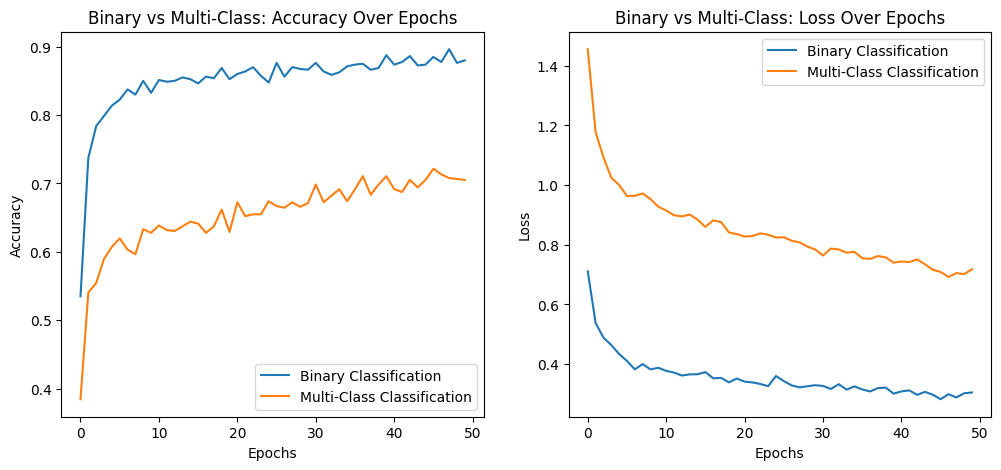

In [101]:
import matplotlib.pyplot as plt

# Plot training accuracy & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_bin.history['accuracy'], label="Binary Classification")
plt.plot(history_multi.history['accuracy'], label="Multi-Class Classification")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Binary vs Multi-Class: Accuracy Over Epochs")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_bin.history['loss'], label="Binary Classification")
plt.plot(history_multi.history['loss'], label="Multi-Class Classification")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Binary vs Multi-Class: Loss Over Epochs")

plt.show()